In [11]:
import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
%matplotlib inline
plt.style.use('seaborn-poster')

from astropy.io import fits
from astropy.convolution import convolve, Box1DKernel
from astropy.time import Time

import spectroscopy as spec
import supernova as sn
import define_filters

In [2]:
cur_dir = os.getcwd()

In [3]:
sn15oz_lc = sn.LightCurve2('asassn15oz')
sn15oz_lc.get_photometry()
sn15oz_lc.get_abs_mag()

# Scale spectroscopy

In [4]:
def scale_spectra(filename, sn15oz_lc):
    cur_dir = os.getcwd()
    date_obs = Time(fits.getval(filename, 'date-obs', 0))
    quba_filename = os.path.join(os.path.split(filename)[0],'{}_scale_phot.ascii'.format(filename.strip('.fits')))
    quba_file = open(quba_filename, 'w')
    quba_hdr = '# name'
    quba_str = '{}'.format(os.path.basename(filename))
    quba_hdr = '{}{}'.format(quba_hdr, ' '*(len(quba_str)-len(quba_hdr)))
    for ifilter in sn15oz_lc.jd.keys():
        cenwave = get_cenwave(ifilter)
        if cenwave > 3500:
            mag, date_sep = get_closest_photometry(date_obs, sn15oz_lc.jd[ifilter], sn15oz_lc.apparent_mag[ifilter])
            if (date_sep < 2) and (len(ifilter)==1):
                quba_str = '{}    {}'.format(quba_str, mag)
                quba_hdr = '{}    {}      '.format(quba_hdr, ifilter)
    quba_file.write('{}\n'.format(quba_hdr))
    quba_file.write(quba_str)
    quba_file.close()

In [5]:
def get_closest_photometry(date_obs, jd, phot_mag):
    date_indx = np.argmin(np.abs(jd - date_obs.jd))
    closest_mag = phot_mag[date_indx]
    date_sep = (jd - date_obs.jd)[date_indx]
    return closest_mag, date_sep
def convert_mag_to_flux(phot_mag, ifilter):
    bandpar_dict = define_filters.define_filters()
    flux = 10**(np.array(phot_mag)/-2.5)*bandpar_dict[ifilter][4]
    return flux
def get_cenwave(ifilter):
    bandpar_dict = define_filters.define_filters()
    cenwave = bandpar_dict[ifilter][2]
    return cenwave

In [6]:
FLOYDS_file1 = os.path.join(os.path.split(cur_dir)[0],'data/spectra/lco/asassn-15oz_20150906_redblu_105042.698a.fits')
FLOYDS_file2 = os.path.join(os.path.split(cur_dir)[0],'data/spectra/lco/asassn15oz_20150916_redblu_120911.274.fits')
FLOYDS_file3 = os.path.join(os.path.split(cur_dir)[0],'data/spectra/lco/asassn15oz_20151014_redblu_112918.305.fits')
FLOYDS_file4 = os.path.join(os.path.split(cur_dir)[0],'data/spectra/lco/asassn-15oz_20151107_redblu_101210.833.fits')

In [7]:
scale_spectra(FLOYDS_file2, sn15oz_lc)

In [8]:
scale_spectra(FLOYDS_file3, sn15oz_lc)

In [9]:
scale_spectra(FLOYDS_file4, sn15oz_lc)

In [51]:

print('cd {}'.format(os.path.split(FLOYDS_file1)[0]) )
print('qubascalespectra.py {} {}'.format('<quba_phot_file>',
                                            '/Users/bostroem/Dropbox/DLT40_all/script/scalespectra/filters/'))

cd /Users/bostroem/Desktop/research/asassn15oz/data/spectra/lco
qubascalespectra.py <quba_phot_file> /Users/bostroem/Dropbox/DLT40_all/script/scalespectra/filters/


# Plot the Spectra

In [13]:
ofile1 = fits.open(os.path.join(os.path.split(FLOYDS_file1)[0],'asassn-15oz_20150906_redblu_105042.698asca.fits'))
ofile2 = fits.open(FLOYDS_file2.replace('.fits', 'sca.fits'))
ofile3 = fits.open(FLOYDS_file3.replace('.fits', 'sca.fits'))
ofile4 = fits.open(FLOYDS_file4.replace('.fits', 'sca.fits'))
flux_floyds1 = ofile1[0].data[0,0,:]
wl_floyds1 = spec.calc_wavelength(ofile1[0].header, np.arange(len(flux_floyds1))+1)
rest_wl_floyds1 = spec.apply_redshift(wl_floyds1, 0.006929 )

flux_floyds2 = ofile2[0].data[0,0,:]
wl_floyds2 = spec.calc_wavelength(ofile2[0].header, np.arange(len(flux_floyds2))+1)
rest_wl_floyds2 = spec.apply_redshift(wl_floyds2, 0.006929 )
flux_floyds3 = ofile3[0].data[0,0,:]
wl_floyds3 = spec.calc_wavelength(ofile3[0].header, np.arange(len(flux_floyds3))+1)
rest_wl_floyds3 = spec.apply_redshift(wl_floyds3, 0.006929 )
flux_floyds4 = ofile4[0].data[0,0,:]
wl_floyds4 = spec.calc_wavelength(ofile4[0].header, np.arange(len(flux_floyds4))+1)
rest_wl_floyds4 = spec.apply_redshift(wl_floyds4, 0.006929 )

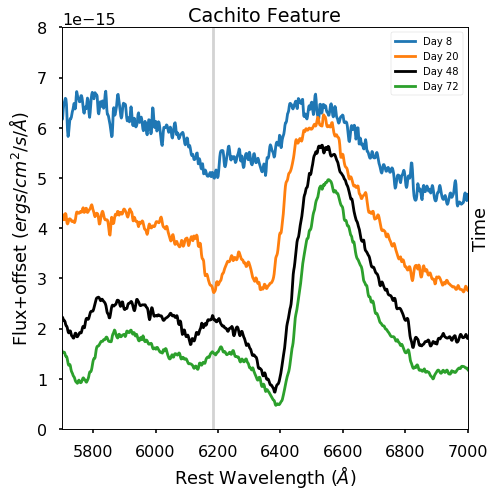

In [17]:
fig = plt.figure(figsize=[7, 7])
ax = fig.add_subplot(111)
ax.axvline(6185, color='LightGray')
ax.plot(rest_wl_floyds1, flux_floyds1+2E-15, label='Day 8')
ax.plot(rest_wl_floyds2, flux_floyds2-1E-15, label='Day 20')
ax.plot(rest_wl_floyds3, flux_floyds3-1E-15,'k', label='Day 48')
ax.plot(rest_wl_floyds4, flux_floyds4-0.5E-15, label='Day 72')
ax.set_xlim(5700, 7000)
ax.set_ylim(0E-15, 8E-15)
ax.set_xlabel('Rest Wavelength ($\AA$)')
ax.set_ylabel('Flux+offset ($ergs/cm^2/s/\AA$)')
ax.set_title('Cachito Feature')
y = ax.twinx()
y.set_yticks([])
y.set_ylabel('Time')
#ax.text(x=6150, y=6.6E-15, s='Cachito\ndisappears\nover\ntime', fontsize='large', backgroundcolor='w', color='k')
ax.legend(loc='upper right', fontsize='medium')
plt.tight_layout()
plt.draw()
plt.savefig('../figures/cachito.pdf')

In [62]:
print(Time('2015-09-04').jd - sn15oz_lc.jdexpl)
print(Time('2015-09-16').jd - sn15oz_lc.jdexpl)
print(Time('2015-10-14').jd - sn15oz_lc.jdexpl)
print(Time('2015-11-07').jd - sn15oz_lc.jdexpl)

7.5
19.5
47.5
71.5
